In [2]:
import elasticsearch
from datetime import datetime
import pandas as pd

In [2]:
!python -V

Python 3.9.7


In [3]:
country="chile"
from_="2022-03-21"
to_="2022-03-27"
media_outlets=["elllanquihue","elaustral","laestrelladechiloe","elheraldoaustral","radiosago",
               "elrepuertero","elvacanudo","elhuemul","seminariolocal","elquellonino","elinsular",
               "radiopudeto","radioacogida","elcalbucano","segundos33",
               "prensadelestuario","fresiaahora","soychiloe"]

#keyword="droga"
simple_keyword=False

In [4]:
IP = "http://search.sophia2.org:9200"
PORT = 9200
USER= "elastic"
PASS= "dummy_elastic"

In [5]:
es = elasticsearch.Elasticsearch(
    IP,
    #port=PORT,
    http_auth=(USER, PASS)
)

In [7]:
match=""
if (simple_keyword):
    match="match"
else:
    match="match_phrase"

query = { 
    "bool": { 
      "must": [
      ],
    "filter": [
        {"range": {
      "date": {
        "gte": from_,
        "lt": to_
      }}},
        { "term":  { "country": country }},
        { "terms":  { "media_outlet": media_outlets }} 
    ]
    }  
}

In [8]:
res = es.search(index="news", query=query, size=1000)
print("Son %d noticias encontradas..." % res['hits']['total']['value'])

Son 189 noticias encontradas...


In [24]:
elasticsearch.__version__

(7, 16, 3)

In [9]:


data = {'id_news':[],'country':[],'media_outlet':[],'url':[],'title':[],'text':[],'date':[],'search':[]}

df = pd.DataFrame(data)  
  
for hit in res['hits']['hits']:
    id_news = hit['_source']['id_news']
    country = hit['_source']['country']
    media_outlet = hit['_source']['media_outlet']
    url = hit['_source']['url']
    title = hit['_source']['title']
    text = hit['_source']['text']
    date = hit['_source']['date']
    search = keyword
    
    new_row = {'id_news':id_news, 'country':country, 'media_outlet':media_outlet, 'url':url, 'title':title, 'text':text, 'date':date, 'search':search}
    
    df = df.append(new_row, ignore_index=True)

df

,id_news,country,media_outlet,url,title,text,date,search
0,47317396.0,chile,radioacogida,https://radioacogida.cl/consejeros-destacan-la...,Consejeros destacan la entrega de 11 vehículos...,Se trata de la entrega oficial de 37 camioneta...,2022-03-25,droga
1,47317540.0,chile,radioacogida,https://radioacogida.cl/gobierno-regional-y-co...,Gobierno Regional y Consejo Regional invitan a...,Desde el dia lunes 21 de marzo y hasta el 25 d...,2022-03-23,droga
2,47325581.0,chile,seminariolocal,https://www.semanariolocal.cl/archivos/4864,Ministro Carlos Montes entrega detalles de la ...,El primer llamado del Subsidio Habitacional pa...,2022-03-21,droga
3,47325585.0,chile,seminariolocal,https://www.semanariolocal.cl/archivos/4858,DP Claudia Pailalef: “Puertas estan abiertas a...,Una importante sesión del Consejo Regional se ...,2022-03-21,droga
4,47330793.0,chile,radiosago,https://www.radiosago.cl/estudiantes-de-escuel...,Estudiantes de Escuela Carlos Condell dejan me...,En el marco de los procesos de formación ciuda...,2022-03-26,droga
...,...,...,...,...,...,...,...,...
184,47670218.0,chile,radiopudeto,http://www.pudeto.cl/?p=57079,Corpocas encabeza encuentro provincial de corp...,"En la ocasión se acordaron diversas acciones, ...",2022-03-25,droga
185,47670220.0,chile,radiopudeto,http://www.pudeto.cl/?p=57069,Centro Acuícola y Pesquero CAPIA UST: investig...,El Centro Acuícola Pesquero de Investigación A...,2022-03-24,droga
186,47670223.0,chile,radiopudeto,http://www.pudeto.cl/?p=57050,ALCALDES CHILOTES SE REUNEN CON EMBAJADORA DE ...,Una reunión con la embajadora de Israel en Ch...,2022-03-22,droga
187,47670224.0,chile,radiopudeto,http://www.pudeto.cl/?p=57046,Municipio de Ancud presenta cartera de proyect...,Son 107 iniciativas que se encuentran en difer...,2022-03-22,droga


In [10]:
df = df.drop_duplicates(subset='url', keep='first')

In [12]:
nombre_archivo="Loslagos_"+country+"_"+from_+"_"+to_+".csv"
print("El archivo se llama:")
print(nombre_archivo)
df.to_csv("./"+nombre_archivo)

El archivo se llama:
Loslagos_chile_2022-03-21_2022-03-27.csv


In [3]:
archivo = "./Loslagos_chile_2022-03-21_2022-03-27.csv"
corpus = pd.read_csv(archivo)

In [4]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)

In [5]:
import numpy as np

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [7]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [8]:
noticias = corpus.text.values.tolist()
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    print(index)
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
nan
[E866] Expected a string or 'Doc' as input, but got: <class 'float'>.
174
175
176
nan
[E866] Expected a string or 'Doc' as input, but got: <class 'float'>.
177
178
179
nan
[E866] Expected a string or 'Doc' as input, but got: <class 'float'>.
180
181
182
183
184
185
186


In [10]:
id2word = corpora.Dictionary(noticias_procesadas)
id2word

In [11]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]


In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
#lda_model.save('./output/lda_model_loslagos')

In [13]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.007*"horas" + 0.007*"año" + 0.007*"personas" + 0.006*"marzo" + '
  '0.005*"día" + 0.005*"agua" + 0.004*"país" + 0.004*"comuna" + 0.004*"pago" + '
  '0.004*"postulación" + 0.004*"años" + 0.003*"vida" + 0.003*"meses" + '
  '0.003*"jornada" + 0.003*"circulación" + 0.003*"sábado" + 0.003*"medidas" + '
  '0.003*"atención" + 0.003*"educación" + 0.003*"vía" + 0.003*"mes" + '
  '0.003*"proceso" + 0.003*"vacunación" + 0.002*"tiempo" + 0.002*"trabajo" + '
  '0.002*"abril" + 0.002*"forma" + 0.002*"horario" + 0.002*"funcionamiento" + '
  '0.002*"estudiantes" + 0.002*"beneficio" + 0.002*"permiso" + '
  '0.002*"comunidad" + 0.002*"región" + 0.002*"martes" + 0.002*"contexto" + '
  '0.002*"sentido" + 0.002*"seguridad" + 0.002*"viernes" + 0.002*"familias" + '
  '0.002*"establecimiento" + 0.002*"territorio" + 0.002*"requisitos" + '
  '0.002*"nivel" + 0.002*"parte" + 0.002*"aguas" + 0.002*"municipio" + '
  '0.002*"importancia" + 0.002*"organización" + 0.002*"recurso" + '
  '0.002*"condiciones" 

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

/home/simon/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010624 -0.130890       1        1  25.284896
4      0.149583  0.126193       2        1  19.565121
3      0.019020 -0.032211       3        1  17.639149
0     -0.027447 -0.053939       4        1  14.509023
2     -0.170975  0.105681       5        1  11.739051
5      0.019195 -0.014835       6        1  11.262760, topic_info=          Term       Freq      Total Category  logprob  loglift
997    mujeres  48.000000  48.000000  Default  30.0000  30.0000
641       agua  67.000000  67.000000  Default  29.0000  29.0000
252    trabajo  74.000000  74.000000  Default  28.0000  28.0000
509    hombres  21.000000  21.000000  Default  27.0000  27.0000
105  proyectos  36.000000  36.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
799     puntos   6.044392  24.005232   Topic6  -5.8293   0.8045
949        vez   5.802372  33.004595   Topic6  -5.8701   0.4453
166   programa   5.491135  27.754312   Topic6  -5.9253   0.5634
543       país   6.064918  65.883774   Topic6  -5.8259  -0.2017
8         años   5.616773  98.364045   Topic6  -5.9027  -0.6792

[401 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
49        1  0.140185                   $
49        5  0.841107                   $
3960      4  0.768953               19:00
3860      6  0.972894  Desafío Levantemos
4880      2  0.840147       Franco Parisi
...     ...       ...                 ...
1601      4  0.768697       ácido nítrico
2579      3  0.126707                área
2579      4  0.253414                área
2579      6  0.506827                área
2145      4  0.906943              órgano

[702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3, 6])

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dataset))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.2733431127632

Coherence Score:  0.4377101811625183


In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
start=2
limit=15
step=1

In [36]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
3
4
5
6
7
8


/home/simon/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/simon/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


9
10
11
12
13
14


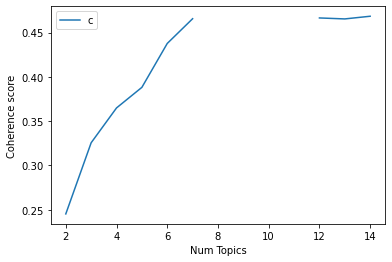

In [37]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2452
Num Topics = 3  has Coherence Value of 0.3256
Num Topics = 4  has Coherence Value of 0.3649
Num Topics = 5  has Coherence Value of 0.3882
Num Topics = 6  has Coherence Value of 0.4377
Num Topics = 7  has Coherence Value of 0.4657
Num Topics = 8  has Coherence Value of nan
Num Topics = 9  has Coherence Value of nan
Num Topics = 10  has Coherence Value of nan
Num Topics = 11  has Coherence Value of nan
Num Topics = 12  has Coherence Value of 0.4665
Num Topics = 13  has Coherence Value of 0.4654
Num Topics = 14  has Coherence Value of 0.4684
